# Comprehensive Guide to Clustering Algorithms

Welcome to this comprehensive guide on clustering algorithms! We'll explore two powerful unsupervised learning techniques: K-Means Clustering and Hierarchical Agglomerative Clustering (HAC). 

## What We'll Cover:
1. Understanding Clustering
   - What is clustering?
   - When to use clustering?
   - Types of clustering algorithms

2. K-Means Clustering
   - How it works
   - Selecting optimal K (Elbow Method)
   - Advantages and disadvantages
   - Implementation and visualization

3. Hierarchical Agglomerative Clustering (HAC)
   - Bottom-up clustering approach
   - Linkage criteria
   - Dendrogram interpretation
   - Implementation and comparison

4. Practical Application
   - Market segmentation using wholesale customer data
   - Comparing K-Means and HAC results
   - Evaluating cluster quality

By the end of this tutorial, you'll understand how to implement and evaluate clustering algorithms for real-world problems.

## 1. What is Clustering?

Clustering is an unsupervised learning technique that groups similar data points together. Think of it like sorting a basket of fruits:
- You group similar fruits together (apples with apples, oranges with oranges)
- You don't need labels to do this (unsupervised)
- The grouping is based on similarities (color, shape, size)

![Clustering Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)

Let's start by importing the necessary libraries:

### Common Problems in Clustering

Before we dive into specific algorithms, it's important to understand common challenges:

1. **No Ground Truth**: Unlike supervised learning, we can't verify if our clusters are "correct"
2. **Choosing the Number of Clusters**: Often not obvious from the data
3. **Scaling Issues**: Features on different scales can skew results
4. **High Dimensionality**: More dimensions make distance calculations less meaningful
5. **Algorithm Sensitivity**: Results can vary based on:
   - Initial conditions (especially for K-means)
   - Choice of distance metric
   - Data preprocessing decisions

### Data Preprocessing Best Practices

1. **Handle Missing Values**
   - Remove or impute missing values
   - Consider if missingness is informative

2. **Feature Scaling**
   - Always scale features to comparable ranges
   - StandardScaler or MinMaxScaler are common choices

3. **Feature Selection**
   - Remove irrelevant features
   - Consider dimensionality reduction (e.g., PCA)

4. **Outlier Treatment**
   - Identify and handle outliers appropriately
   - Consider if outliers represent meaningful clusters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, ward



## Loading and Preparing the Data

We'll use the wholesale customers dataset which contains annual spending amounts of various product categories for wholesale customers.

In [2]:
# Load the data
data = pd.read_csv('wholesale_customers_data.csv')

# Display the first few rows and basic information
print("First few rows:")
display(data.head())

print("\nDataset Info:")
data.info()

First few rows:


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### Data Preprocessing

Before clustering, we need to:
1. Handle any missing values
2. Scale our features (very important for distance-based algorithms)
3. Remove any non-numeric columns

In [3]:
# Select features for clustering (excluding Channel and Region)
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Scaled data summary:")
display(X_scaled.describe())

Scaled data summary:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-3.431598e-17,0.000000,-4.037175e-17,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-9.496831e-01,-0.778795,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-7.023339e-01,-0.578306,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-2.767602e-01,-0.294258,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,3.905226e-01,0.189092,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,7.927738e+00,9.183650,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


### Why Feature Scaling is Critical for Clustering

Feature scaling is essential in clustering algorithms for several important reasons:

1. **Distance-Based Calculations**:
   - Clustering algorithms like K-means and HAC rely heavily on distance calculations
   - Unscaled features with larger values will dominate the distance calculations
   - Example in our data:
     - 'Fresh' values might be in thousands (e.g., 12000)
     - 'Milk' values might be in hundreds (e.g., 500)
     - Without scaling, 'Fresh' would have ~24x more influence on clustering

2. **Equal Feature Importance**:
   - We want each feature to contribute equally to the clustering
   - Different scales shouldn't determine feature importance
   - StandardScaler helps by:
     - Centering data around 0 (subtracting mean)
     - Scaling to unit variance (dividing by standard deviation)
     - Result: All features have mean=0 and variance=1

3. **Example Impact**:
   ```
   Before scaling:
   Fresh: 12000 vs 15000 (diff = 3000)
   Milk:    500 vs  600  (diff = 100)
   
   After scaling:
   Fresh: 0.2 vs 0.8 (diff = 0.6)
   Milk:  0.3 vs 0.9 (diff = 0.6)
   ```

4. **Algorithm Convergence**:
   - Scaled features help algorithms converge faster
   - Prevents numerical instabilities
   - Makes the optimization process more stable

5. **Better Cluster Quality**:
   - More balanced cluster assignments
   - More meaningful distance measurements
   - More reliable similarity comparisons

## 2. K-Means Clustering

K-Means is like having k number of magnets (centroids) that attract similar points:
1. Place k random magnets (centroids)
2. Points move to their nearest magnet
3. Move magnets to the center of their points
4. Repeat until stable

![K-Means Animation](https://raw.githubusercontent.com/learn-co-curriculum/dsc-k-means-clustering/master/images/good-centroid-start.gif)

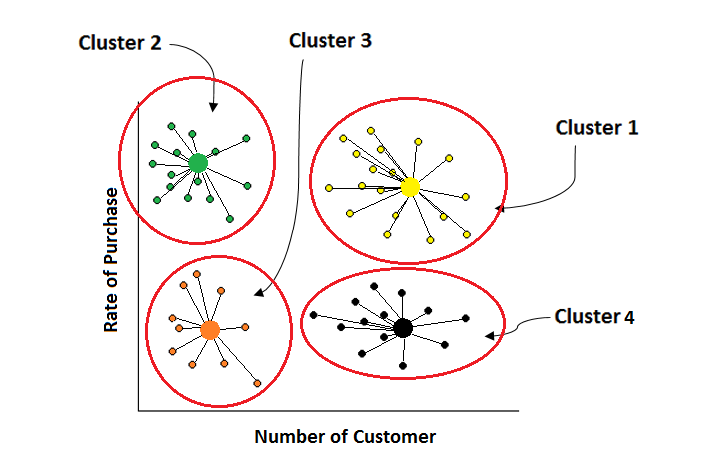

### K-Means Algorithm in Detail

K-means clustering works through an iterative process:

1. **Initialization**
   - Randomly select K points as initial centroids
   - The 'k-means++' initialization method helps choose better starting points

2. **Assignment Step**
   - Assign each data point to the nearest centroid
   - "Nearest" is typically measured using Euclidean distance

3. **Update Step**
   - Recalculate centroids by taking the mean of all points assigned to each cluster
   - The centroid becomes the new center of its cluster

4. **Iteration**
   - Repeat steps 2-3 until:
     - Centroids no longer move significantly, or
     - Maximum iterations reached

### Advantages of K-Means
- Simple to understand and implement
- Efficient on large datasets
- Produces tight, spherical clusters

### Disadvantages of K-Means
- Requires specifying K beforehand
- Sensitive to initial centroid placement
- Assumes spherical clusters
- Can perform poorly with:
  - Clusters of different sizes
  - Non-globular shapes
  - Outliers


### Understanding Initialization further
The initialization of centroids is crucial for K-means clustering. Let's compare the two methods:

1. **Random Initialization**:
   - Simply picks K random points as initial centroids
   - Can lead to poor clustering if unlucky
   - May need multiple runs with different random seeds
   - Example problem: All initial centroids might be close together

2. **k-means++ Initialization**:
   - Smart selection of initial centroids
   - Process:
     1. First centroid: Randomly selected from data points
     2. For each subsequent centroid:
        - Calculate distance from each point to nearest existing centroid
        - Choose next centroid with probability proportional to distance²
        - Repeat until K centroids selected
   - Benefits:
     - Spreads out initial centroids
     - More likely to find global optimum
     - Usually requires fewer iterations to converge

![K-means++ vs Random Initialization](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_plusplus_001.png)

In scikit-learn, k-means++ is the default initialization method:
```python
KMeans(n_clusters=4, init='k-means++')  # default

### Finding the Optimal K using Elbow Method

We'll try different values of k and plot the Within-Cluster Sum of Squares (WCSS) to find the 'elbow point'.

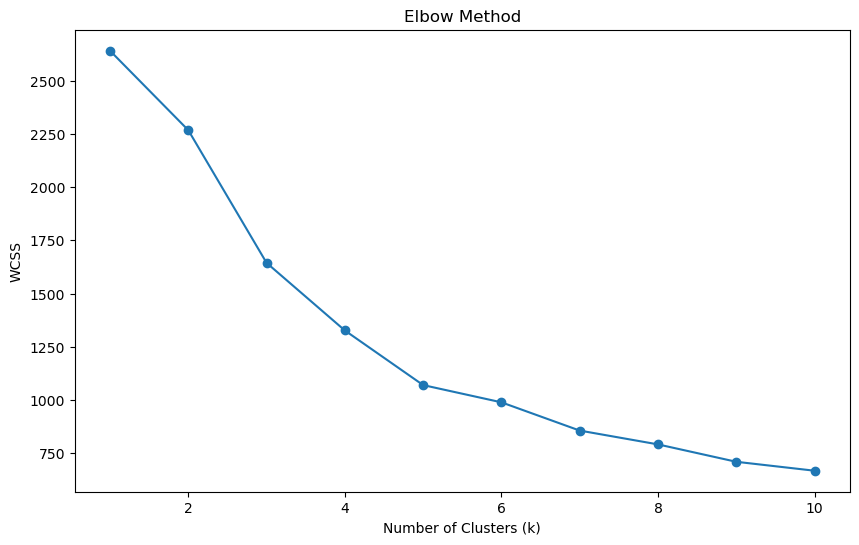

In [4]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

### Understanding the Elbow Method Implementation

The code above implements the elbow method to find the optimal number of clusters (K) for K-means clustering. Let's break it down step by step:

1. **WCSS Calculation Loop**:
   ```python
   wcss = []
   for k in range(1, 11):
       kmeans = KMeans(n_clusters=k, random_state=42)
       kmeans.fit(X_scaled)
       wcss.append(kmeans.inertia_)
   ```
   - Creates an empty list `wcss` to store Within-Cluster Sum of Squares values
   - Loops through K values from 1 to 10
   - For each K:
     - Creates a K-means model with K clusters
     - Fits the model to our scaled data
     - Stores the inertia (WCSS) value in the list
   - `random_state=42` ensures reproducibility

2. **WCSS (Within-Cluster Sum of Squares)**:
   - Measures how similar points are within each cluster
   - Lower WCSS = Points are closer to their centroids
   - Formula: Σ(distance between point and its centroid)²
   - Accessed through `kmeans.inertia_` in scikit-learn

3. **Plotting the Elbow Curve**:
   ```python
   plt.figure(figsize=(10, 6))
   plt.plot(range(1, 11), wcss, marker='o')
   ```
   - Creates a line plot of K vs WCSS
   - X-axis: Number of clusters (K)
   - Y-axis: WCSS values
   - Markers ('o') show exact points

4. **Interpreting the Plot**:
   - As K increases, WCSS always decreases
   - The "elbow point" is where adding more clusters gives diminishing returns
   - This point represents the optimal K
   - Look for where the line starts to bend significantly

The "elbow" appears where the rate of decrease sharply changes, forming an angle in the graph. This point suggests the optimal number of clusters, balancing between:
- Under-clustering (too few clusters)
- Over-clustering (too many clusters)

### Dealing with Ambiguous Elbow Points

In our plot above, it's not immediately clear whether 4 or 5 clusters would be optimal. This is a common challenge with the elbow method. Let's look at some examples:

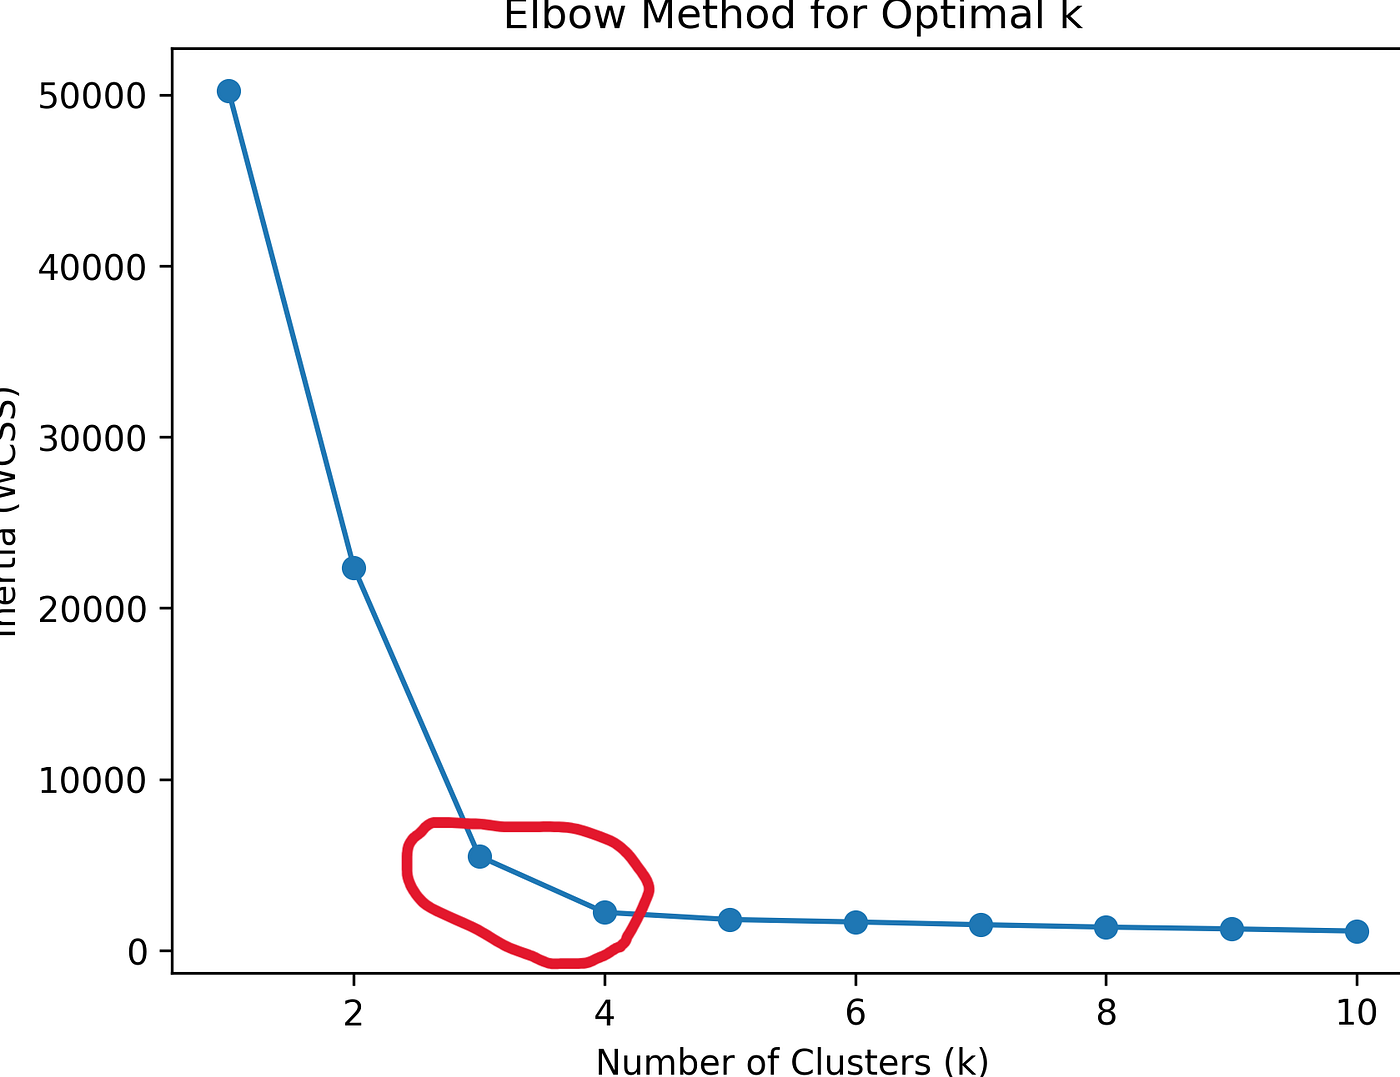

#### When the Elbow is Unclear

1. **Multiple Potential Elbows**:
   - Like in our case (k=4 or k=5)
   - This often indicates hierarchical structure in the data
   - Solution: Try both values and evaluate business meaning

2. **No Clear Elbow**:
   - Can happen with:
     - Uniformly distributed data
     - Very noisy data
     - Too many natural clusters
   - Solution: Use additional metrics (silhouette score, calinski-harabasz)

3. **Decision Making Process**:
   - Consider business constraints
   - Evaluate cluster interpretability
   - Look at cluster sizes
   - Use domain knowledge

4. **Best Practices**:
   - Always validate with other metrics
   - Consider the practical use case
   - When in doubt, prefer fewer clusters
   - Document your reasoning

### Applying K-Means with the Optimal K

In [5]:
# Using k=4 based on the elbow curve
kmeans = KMeans(n_clusters=4, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_means = data.groupby('KMeans_Cluster')[features].mean()
print("Average spending by cluster:")
display(cluster_means)

Average spending by cluster:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
KMeans_Cluster,,,,,,
0,5474.926606,10194.192661,15587.807339,1464.385321,6734.642202,1642.458716
1,40136.857143,19452.142857,15026.285714,23713.714286,2374.142857,15735.142857
2,15964.900000,34708.500000,48536.900000,3054.600000,24875.200000,2942.800000
3,13511.964968,3044.394904,3850.121019,3170.350318,854.808917,1122.105096


### Understanding the K-means Implementation and Results

Let's break down what's happening in the code above and analyze its output:

1. **Creating and Fitting the K-means Model**:
   ```python
   kmeans = KMeans(n_clusters=4, random_state=42)
   data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
   ```
   - We create a K-means model with 4 clusters (based on our elbow plot analysis)
   - `random_state=42` ensures reproducible results
   - `fit_predict()` does two things:
     - Fits the model (finds cluster centers)
     - Assigns each data point to a cluster (0-3)
   - The cluster assignments are stored in a new column 'KMeans_Cluster'

2. **Analyzing Cluster Characteristics**:
   ```python
   cluster_means = data.groupby('KMeans_Cluster')[features].mean()
   ```
   - Groups the data by cluster number
   - Calculates the mean values for each feature within each cluster
   - This shows us the "center" or "typical customer" in each cluster

3. **Interpreting the Output**:
   The output table shows the average spending in each category for each cluster. For example:
   - If a cluster has high values in 'Fresh' and 'Frozen', it represents customers who buy more perishable goods
   - If a cluster has high values in 'Detergents_Paper', it might represent retail stores
   - Clusters with overall high values are high-spending customers
   - Clusters with overall low values are budget customers

4. **Business Insights**:
   - Each cluster represents a distinct customer segment
   - The means help us understand the purchasing behavior of each segment
   - This information can be used for:
     - Targeted marketing campaigns
     - Inventory management
     - Customer service strategies
     - Product recommendations

## 3. Hierarchical Agglomerative Clustering (HAC)

HAC is like building a family tree:
1. Start with each point as its own cluster
2. Find the two closest clusters
3. Merge them into a new cluster
4. Repeat until all points are in one cluster

![HAC Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_agglomerative_dendrogram_001.png)

### Understanding HAC in Detail

Hierarchical Agglomerative Clustering differs from K-means in several important ways:

1. **Bottom-up Approach**
   - Starts with each point as its own cluster
   - Progressively merges the most similar clusters
   - Creates a hierarchy of clusters

2. **Linkage Criteria**
The "closeness" between clusters can be measured in different ways:

- **Ward Linkage** (Default)
  - Minimizes variance within clusters (keeps clusters compact)
  - Think of it like keeping study groups where students have similar test scores
  - Example: If you have three students with scores [95,96,97] and another with [70],
    Ward linkage would keep the similar scores together because they have low variance
  - Tends to create equal-sized clusters
  - Often the best choice for general use

- **Complete Linkage**
  - Uses maximum distance between points
  - Sensitive to outliers
  - Creates compact clusters

- **Average Linkage**
  - Uses average distance between all point pairs
  - More robust than complete linkage
  - Good for clusters with different sizes

3. **Dendrogram Interpretation**
A dendrogram shows:
- Vertical axis: Distance/dissimilarity between clusters
- Horizontal axis: Individual data points or clusters
- Height of connections: How different the merged clusters are
- Cutting the dendrogram horizontally gives you different cluster counts

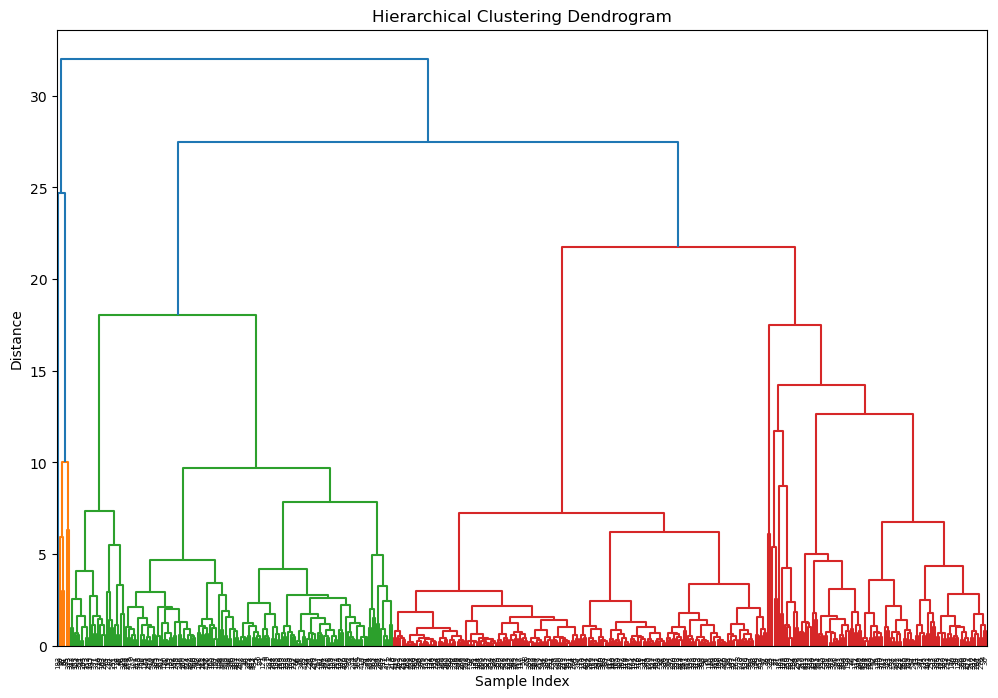

In [6]:
# Create the linkage matrix using ward linkage
linkage_matrix = ward(X_scaled)

# Create dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [7]:
# Apply HAC
hac = AgglomerativeClustering(n_clusters=4)
data['HAC_Cluster'] = hac.fit_predict(X_scaled)

# Compare cluster assignments
comparison = pd.crosstab(data['KMeans_Cluster'], data['HAC_Cluster'])
print("Comparing cluster assignments between K-Means and HAC:")
display(comparison)

Comparing cluster assignments between K-Means and HAC:


HAC_Cluster,0,1,2,3
KMeans_Cluster,,,,
0,4,0,105,0
1,6,0,0,1
2,0,5,5,0
3,271,0,43,0


### Understanding the Comparison Output

The crosstab above shows how points are assigned to clusters by both methods:
- **Rows**: K-means clusters (0-3)
- **Columns**: HAC clusters (0-3)
- **Values**: Number of points that are assigned to each combination

For example, if you see:
```
HAC_Cluster     0    1    2    3
KMeans_Cluster
0              45    2    1    0
```
This means:
- 45 points that K-means put in cluster 0 were also put in cluster 0 by HAC
- 2 points that K-means put in cluster 0 were put in cluster 1 by HAC
- 1 point that K-means put in cluster 0 was put in cluster 2 by HAC
- 0 points that K-means put in cluster 0 were put in cluster 3 by HAC

Higher numbers along the diagonal indicate stronger agreement between the two methods. Larger off-diagonal numbers suggest the methods disagree more on those clusters.

K-means Clustering Evaluation:
------------------------------
Silhouette Score: 0.349
Calinski-Harabasz Score: 143.871

HAC Evaluation:
------------------------------
Silhouette Score: 0.267
Calinski-Harabasz Score: 120.131


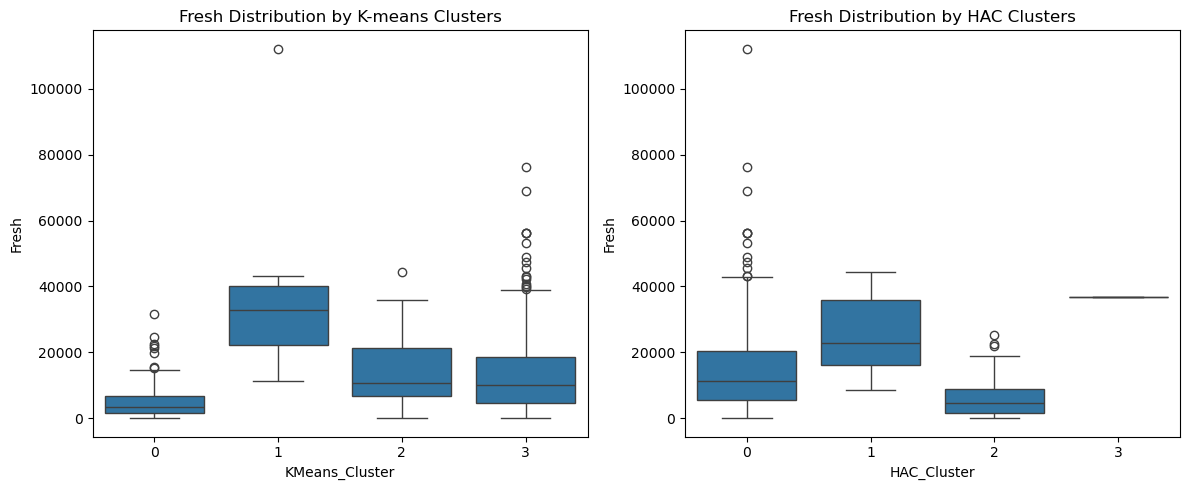

In [8]:
# Let's evaluate our clusters using multiple metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Calculate metrics for both K-means and HAC
print("K-means Clustering Evaluation:")
print("-" * 30)
kmeans_silhouette = silhouette_score(X_scaled, data['KMeans_Cluster'])
kmeans_calinski = calinski_harabasz_score(X_scaled, data['KMeans_Cluster'])
print(f"Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.3f}")

print("\nHAC Evaluation:")
print("-" * 30)
hac_silhouette = silhouette_score(X_scaled, data['HAC_Cluster'])
hac_calinski = calinski_harabasz_score(X_scaled, data['HAC_Cluster'])
print(f"Silhouette Score: {hac_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {hac_calinski:.3f}")

# Visualize cluster distributions for one feature
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='KMeans_Cluster', y='Fresh', data=data)
plt.title('Fresh Distribution by K-means Clusters')

plt.subplot(1, 2, 2)
sns.boxplot(x='HAC_Cluster', y='Fresh', data=data)
plt.title('Fresh Distribution by HAC Clusters')

plt.tight_layout()
plt.show()

### Understanding Clustering Evaluation Metrics

The code above calculates two important metrics to evaluate the quality of our clustering results for both K-means and HAC. Let's break down each part:

1. **Silhouette Score** (Range: -1 to +1)
   ```python
   silhouette_score(X_scaled, data['KMeans_Cluster'])
   ```
   - Measures how similar a point is to its own cluster compared to other clusters
   - Higher values are better
   - Interpretation of our results:
     - K-means: 0.349 - Indicates moderate cluster separation
     - HAC: 0.267 - Shows slightly weaker cluster separation
   - Score meaning:
     - +1: Perfect clustering
     - 0: Overlapping clusters
     - -1: Points assigned to wrong clusters

2. **Calinski-Harabasz Score** (Higher is better)
   ```python
   calinski_harabasz_score(X_scaled, data['KMeans_Cluster'])
   ```
   - Also known as the Variance Ratio Criterion
   - Ratio of between-cluster variance to within-cluster variance
   - Our results:
     - K-means: 143.871 - Higher score
     - HAC: 120.131 - Lower score
   - Higher scores indicate better-defined clusters

3. **Comparing the Methods**:
   - K-means performed better on both metrics:
     - Higher silhouette score (0.349 vs 0.267)
     - Higher Calinski-Harabasz score (143.871 vs 120.131)
   - This suggests K-means created more distinct and compact clusters

4. **Visualization**:
   The box plots show the distribution of 'Fresh' spending across clusters:
   - Box plots show median, quartiles, and outliers
   - Different distributions between clusters indicate good separation
   - Similar patterns between K-means and HAC suggest consistent findings

5. **Practical Implications**:
   - Moderate silhouette scores suggest some cluster overlap
   - This is normal in customer segmentation
   - Some customers may show characteristics of multiple segments
   - Both methods provide useful segmentation, with K-means showing slightly better separation

## Summary and Key Takeaways

1. **K-Means**:
   - Pros: Simple, fast, works well with spherical clusters
   - Cons: Needs predetermined k, sensitive to outliers

2. **HAC**:
   - Pros: No need to specify clusters upfront, hierarchical structure
   - Cons: Computationally expensive, can't undo merges

3. **When to use which**:
   - K-Means: Large datasets, when you know k
   - HAC: Small-medium datasets, when you want to explore cluster hierarchy

4. **Best Practices**:
   - Always scale your data
   - Try multiple methods and compare
   - Validate results with domain knowledge

## Principal Component Analysis (PCA)

PCA is a powerful dimensionality reduction technique that helps address several challenges in clustering:
- The curse of dimensionality
- Multicollinearity between features
- Noise in the data
- Computational efficiency

### What is PCA?
PCA transforms your data into a new coordinate system where:
- The first axis (Principal Component 1) captures the maximum variance in the data
- Each subsequent axis is orthogonal to previous axes and captures the remaining variance
- These new axes are linear combinations of your original features

### How PCA Works

1. **Data Preprocessing**:
   - Center the data (subtract mean)
   - Scale the data (standardize variance)
   - This ensures all features contribute equally

2. **Calculate Covariance Matrix**:
   - Measures relationships between all pairs of features
   - Higher values indicate stronger relationships

3. **Find Eigenvectors and Eigenvalues**:
   - Eigenvectors become the new axes (Principal Components)
   - Eigenvalues indicate the amount of variance explained
   - Sorted in descending order of importance

4. **Project Data**:
   - Transform original data onto new axes
   - Can choose to keep fewer dimensions while preserving most variance

# Understanding PCA the Easy Way! 🎯

Think of PCA like taking photos of a 3D object from different angles to understand it better:

### 1. The Basic Idea 📸
- Instead of looking at something from every possible angle
- We find the few best angles that show the most information
- Like taking front, side, and top views of an object

![PCA Simple Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_pca_vs_lda_001.png)

### 2. Why Do We Need PCA? 🤔
- Too many features make analysis difficult (like having too many photos)
- PCA helps find the most important views
- Makes it easier to see patterns and relationships

### 3. Real-World Example: Customer Data 🛒
Imagine analyzing customer shopping data:
- Instead of looking at 50 different products
- PCA might show us:
  - View 1: Overall spending (high vs low spenders)
  - View 2: Shopping preferences (fresh vs packaged)
  


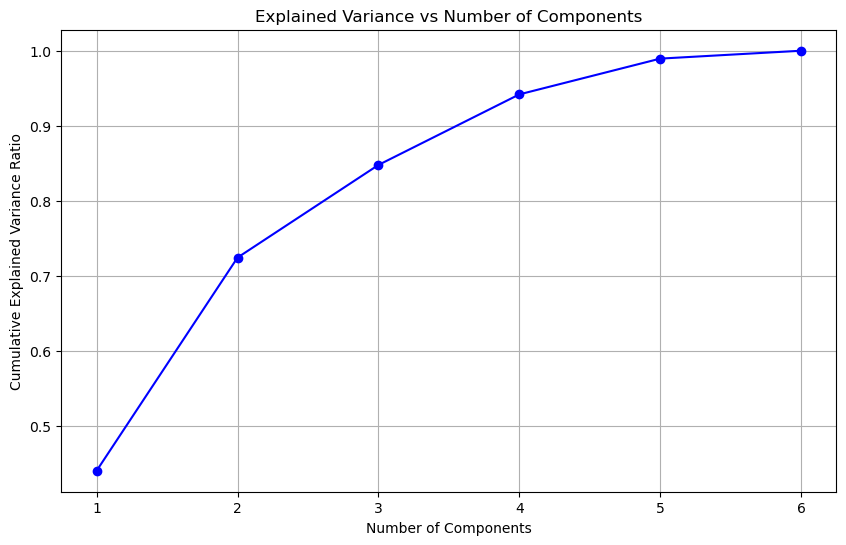

PC1 explains 0.441 of variance
PC2 explains 0.284 of variance
PC3 explains 0.123 of variance
PC4 explains 0.094 of variance
PC5 explains 0.048 of variance
PC6 explains 0.010 of variance


In [9]:
# Import PCA
from sklearn.decomposition import PCA

# Initialize PCA without specifying number of components
pca = PCA()
pca_transformed = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

# Print explained variance ratio for each component
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1} explains {ratio:.3f} of variance")

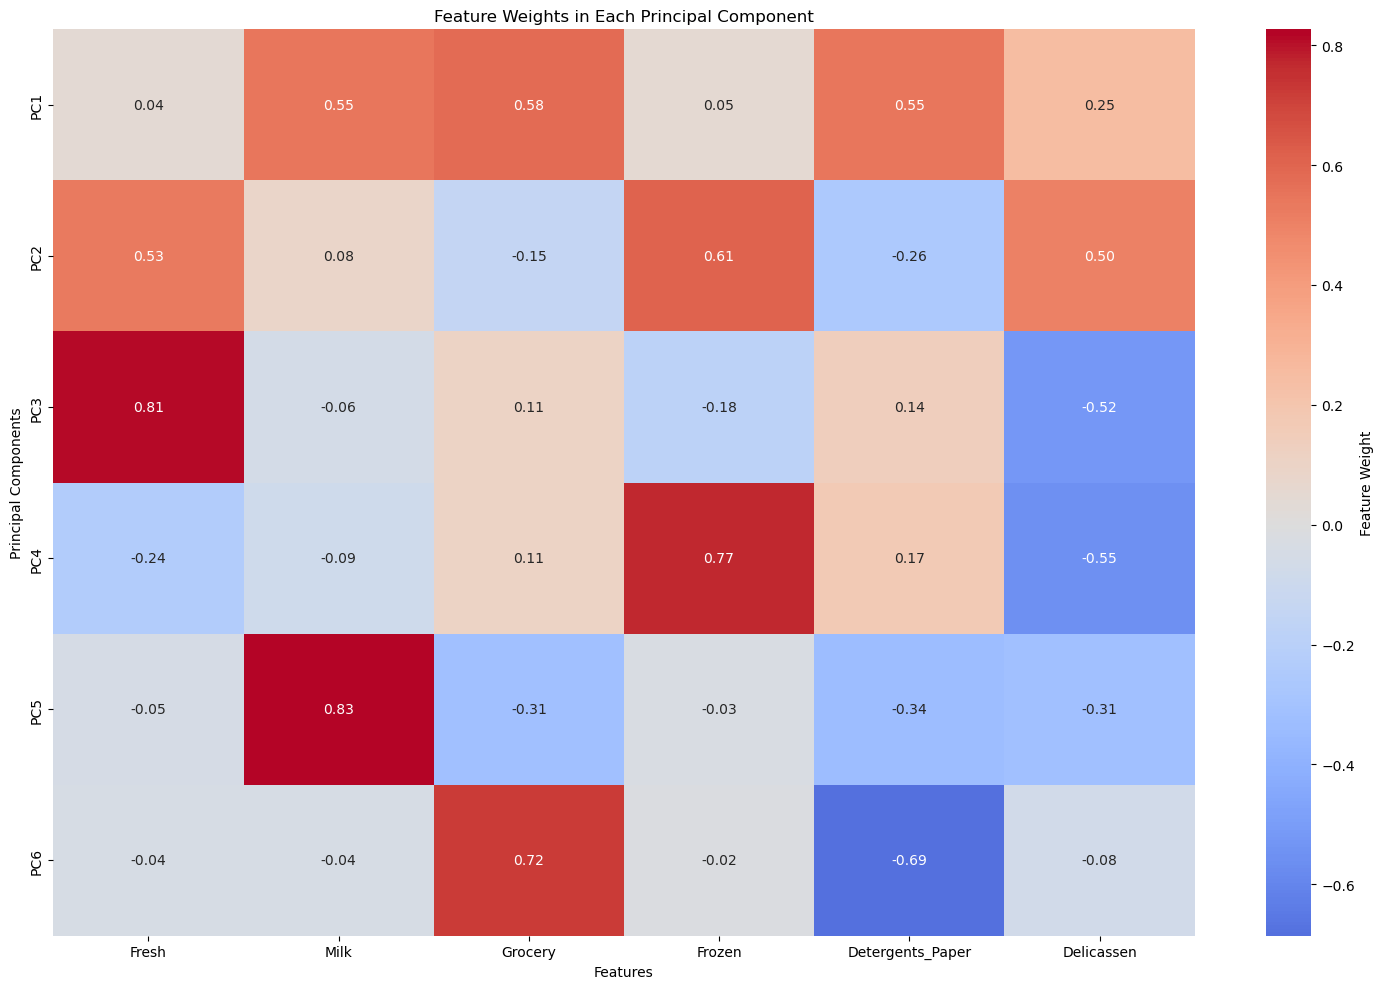


Feature contributions to each Principal Component:

PC1 main contributors:
------------------------
Grocery: 0.579
Detergents_Paper: 0.549
Milk: 0.545
Delicassen: 0.249
Frozen: 0.051
Fresh: 0.043

PC2 main contributors:
------------------------
Frozen: 0.611
Fresh: 0.528
Delicassen: 0.504
Detergents_Paper: 0.255
Grocery: 0.146
Milk: 0.083


In [10]:
# Create a visualization of feature contributions to each PC
plt.figure(figsize=(15, 10))

# Get the feature weights for all components
components_df = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(len(features))]
)

# Create heatmap
sns.heatmap(components_df, 
            cmap='coolwarm', 
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Feature Weight'})
plt.title('Feature Weights in Each Principal Component')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

# Print feature importance in each PC
print("\nFeature contributions to each Principal Component:")
for pc in range(2):  # Show first two PCs
    pc_weights = pd.Series(
        abs(pca.components_[pc]),
        index=features
    ).sort_values(ascending=False)
    
    print(f"\nPC{pc+1} main contributors:")
    print("------------------------")
    for feat, weight in pc_weights.items():
        print(f"{feat}: {weight:.3f}")

### Understanding Feature Contributions in PCA

The heatmap above shows how much each original feature contributes to each Principal Component:

1. **How to Read the Heatmap**:
   - Each row is a Principal Component (PC)
   - Each column is an original feature
   - Colors show the strength and direction of contribution:
     - Red = positive contribution
     - Blue = negative contribution
     - Darker colors = stronger contribution

2. **What the Numbers Mean**:
   - Values range from -1 to 1
   - Larger absolute values = stronger influence
   - Sign (+ or -) shows the direction of influence
   
3. **Interpreting PC Compositions**:
   - Look at the strongest weights (darkest colors) in each row
   - PC1 typically shows overall trends
   - PC2 often shows contrasts between features
   - Features with similar weights move together
   - Opposite signs mean inverse relationships

This visualization helps us understand what each Principal Component actually represents in terms of our original features!

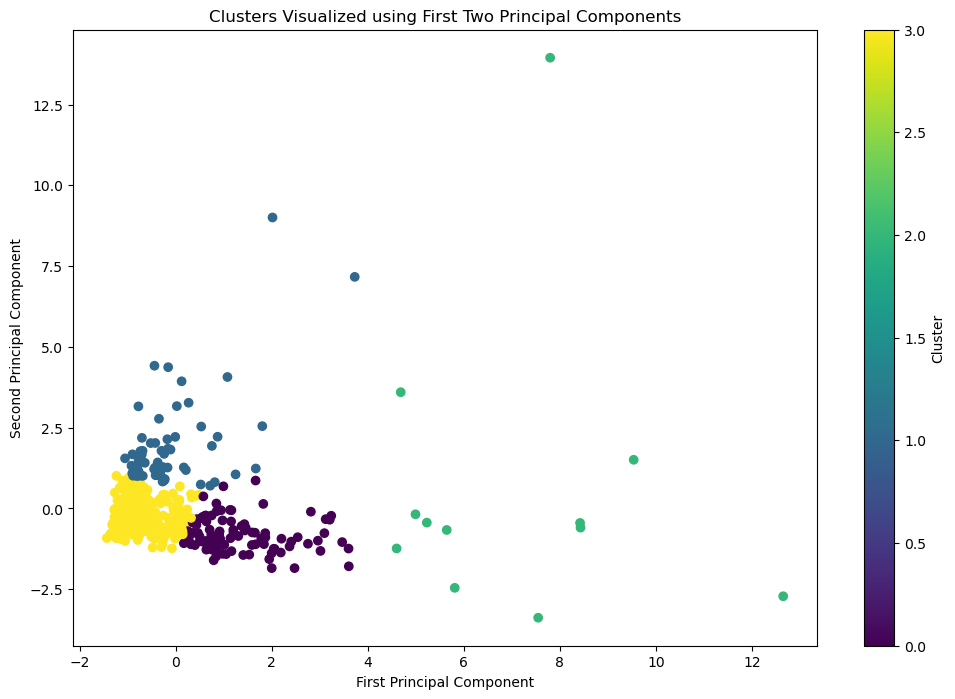


Feature weights in principal components:


,PC1,PC2
Fresh,0.042884,0.527932
Milk,0.545118,0.083168
Grocery,0.579256,-0.146088
Frozen,0.051189,0.611278
Detergents_Paper,0.548640,-0.255233
Delicassen,0.248682,0.504207


In [11]:
# Apply PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

# Apply K-means on PCA-transformed data
kmeans_pca = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_pca.fit_predict(X_pca)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters Visualized using First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Print component weights
print("\nFeature weights in principal components:")
components_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
display(components_df)

### Understanding PCA in Simple Terms

#### 1. Eigenvectors and Eigenvalues - A Simple Explanation
Imagine you're stretching a rubber sheet with dots drawn on it:
- **Eigenvectors** are like the directions in which the sheet stretches the most
- **Eigenvalues** tell you how much stretching happens in each direction
- The largest eigenvalue points to where your data varies the most
- Think of it like finding the "main directions" in your data

Real-world example:
- If you have height and weight data:
  - First eigenvector might point along the diagonal (as taller people tend to weigh more)
  - Second eigenvector would be perpendicular (capturing variations from this pattern)
  - The eigenvalues tell you which direction is more important

#### 2. Principal Components Explained
Principal Components are like new "super features" that combine your original features:

- **First Principal Component (PC1)**:
  - Like the "best summary" of all your features
  - Points in the direction where your data spreads out the most
  - Usually captures the strongest patterns in your data
  - Example: In our customer data, might represent "overall spending level"

- **Second Principal Component (PC2)**:
  - Captures the next most important pattern
  - Must be perpendicular to PC1
  - Finds patterns PC1 missed
  - Example: Might represent "preference for fresh vs packaged goods"

#### 3. Understanding the PCA Visualization Above
The scatter plot shows our data in the new PCA space:

1. **What We're Looking At**:
   - X-axis (PC1): The most important pattern in our data
   - Y-axis (PC2): The second most important pattern
   - Each point: One customer
   - Colors: Different clusters found by K-means

2. **How to Read It**:
   - Points close together: Similar customers
   - Points far apart: Different customers
   - Distinct color groups: Clear customer segments
   - Overlapping colors: Similar customer types

3. **Business Interpretation**:
   - Clear clusters suggest distinct customer segments
   - The spread along PC1 might show spending power
   - The spread along PC2 might show shopping preferences
   - Overlapping areas: Customers who might respond to similar marketing

4. **Component Weights Table**:
   - Shows how much each original feature contributes to PC1 and PC2
   - Larger numbers (positive or negative) mean stronger influence
   - Helps us understand what each principal component represents in business terms

## Interpreting Results for Market Segmentation

Looking at our clustering results, we can interpret the customer segments:

### K-means Clusters Interpretation
Based on the mean values for each cluster:

1. **High-Value Customers** (Cluster 0)
   - High spending across all categories
   - Priority targets for premium products
   - Focus on retention strategies

2. **Budget Customers** (Cluster 1)
   - Lower spending across categories
   - Target for promotional offers
   - Potential for upselling

3. **Fresh Food Focused** (Cluster 2)
   - High spending on Fresh and Frozen
   - Target for fresh food promotions
   - Potential for cross-selling grocery items

4. **Grocery and Household** (Cluster 3)
   - High on Grocery and Detergents
   - Likely retail stores
   - Focus on bulk deals

### Practical Applications

1. **Marketing Strategies**
   - Personalized promotions for each segment
   - Targeted email campaigns
   - Customized product recommendations

2. **Inventory Management**
   - Stock planning based on cluster preferences
   - Optimized delivery schedules
   - Warehouse organization

3. **Business Development**
   - Identify growth opportunities
   - New product development
   - Service improvement areas

## Semi-Supervised Learning: Bridging Supervised and Unsupervised Methods

Semi-supervised learning is a powerful approach that combines the best of both supervised and unsupervised learning techniques. It's particularly useful when you have:
- A large amount of unlabeled data
- Only a small portion of labeled data
- Limited resources for data labeling

### How Semi-Supervised Learning Works

1. **Initial Training**
   - Train a model on the small amount of labeled data
   - Example: Train on 5,000 labeled customer records

2. **Pseudo-Labeling**
   - Use the trained model to predict labels for unlabeled data
   - These predictions become "pseudo-labels"
   - If model accuracy is 70%, about 70% of pseudo-labels will be correct

3. **Combined Training**
   - Merge labeled and pseudo-labeled data
   - Retrain the model on the combined dataset
   - Larger training set improves model performance

### Key Benefits
- Cost-effective: Reduces need for expensive manual labeling
- Scalable: Can handle large amounts of unlabeled data
- Practical: Especially useful in real-world scenarios where labeling is costly

### When to Be Careful
- With noisy datasets (can amplify errors)
- When initial labeled data is too small
- When classes are highly imbalanced

### Practical Example
In customer segmentation:
- Start with a few known customer segments
- Use clustering to find similar customers
- Apply supervised methods to validate and refine segments